<a href="https://colab.research.google.com/github/guebin/MP2024/blob/main/quiz/Quiz-5.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

| **항목**               | **허용 여부**        | **비고**                                          |
|------------------------|----------------------|---------------------------------------------------|
| **강의노트 참고**      | 허용                 | 수업 중 제공된 강의노트나 본인이 정리한 자료를 참고 가능       |
| **구글 검색**          | 허용                 | 인터넷을 통한 자료 검색 및 정보 확인 가능        |
| **생성 모형 사용**           | 허용 안함            | 인공지능 기반 도구(GPT 등) 사용 불가            |

```bash
!pip install pytorchvideo evaluate
```

In [85]:
import huggingface_hub
import tarfile 
import transformers
import pytorchvideo.data
import pytorchvideo.transforms
import torchvision.transforms
import evaluate
import torch
import numpy as np
import imageio
import IPython.display
import matplotlib.pyplot as plt 

# 1. 동영상자료의 이해 -- 40점

In [ ]:
file_path = huggingface_hub.hf_hub_download(
    repo_id="sayakpaul/ucf101-subset", 
    filename="UCF101_subset.tar.gz", 
    repo_type="dataset"
)
with tarfile.open(file_path) as t:
    t.extractall(".")


`(1)` 아래의 코드를 이용하여 "UCF101_subset/test/BenchPress/v_BenchPress_g05_c02.avi" 를 텐서의 형태로 불러오라.

In [82]:
video_path = "UCF101_subset/test/BenchPress/v_BenchPress_g05_c02.avi"
video = pytorchvideo.data.encoded_video.EncodedVideo.from_path(video_path).get_clip(0, float('inf'))['video']

위 코드로 불러온 동영상의 흑백/컬러 여부, 프레임 수, 높이(height), 너비(width) 를 확인하라. -- 10점

`(2)` `video`의 마지막 프레임에 해당하는 이미지를 출력하라. -- 10점

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


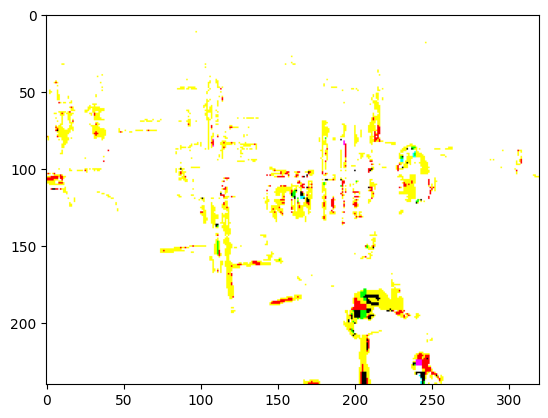

In [98]:
# 아래와 같은 이미지가 출력되면 정답인정 X 

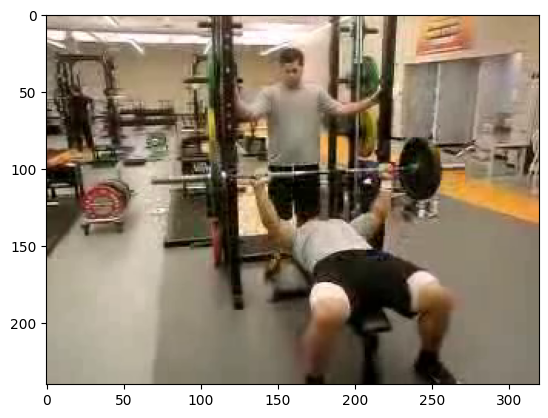

In [100]:
# 이러한 이미지만 정답으로 인정

`(3)` 이 동영상을 확인할 수 있는 적당한 함수 `display_gif`를 선언하고 동영상을 확인하라. -- 10점

`(4)` 주어진 동영상에 아래의 변환을 적용한 후, `display_gif` 함수를 사용하여 결과를 확인하라. -- 10점

- `pytorchvideo.transforms.UniformTemporalSubsample(4)`: 프레임 수를 4개로
- `torchvision.transforms.Resize((112, 112))`: 이미지 크기를 112x112로 조정


# 2. `ucf101-subset` 분석 -- 60점

`(1)` 아래의 코드와 설정을 이용하여 VideoMAE 모델을 선언하고, `ucf101-subset` 데이터셋을 변환하여 학습하라. -- 50점

**모델선언**

- 프레임 수: 4
- 이미지 크기: 112x112
- 클래스 레이블 매핑: label2id와 id2label

In [111]:
label2id = {
    'ApplyEyeMakeup': 0,
    'ApplyLipstick': 1,
    'Archery': 2,
    'BabyCrawling': 3,
    'BalanceBeam': 4,
    'BandMarching': 5,
    'BaseballPitch': 6,
    'Basketball': 7,
    'BasketballDunk': 8,
    'BenchPress': 9
}
id2label = {
    0: 'ApplyEyeMakeup',
    1: 'ApplyLipstick',
    2: 'Archery',
    3: 'BabyCrawling',
    4: 'BalanceBeam',
    5: 'BandMarching',
    6: 'BaseballPitch',
    7: 'Basketball',
    8: 'BasketballDunk',
    9: 'BenchPress'
}
config = transformers.VideoMAEConfig.from_pretrained("MCG-NJU/videomae-base")
config.num_frames = 4  # 프레임 수를 4로 조정
config.label2id = label2id
config.id2label = id2label
config.image_size = 112   # 이미지 크기를 112x112로 조정

# 설정된 config로 모델 선언
model = transformers.VideoMAEForVideoClassification.from_pretrained(
    "MCG-NJU/videomae-base",
    config=config,
    ignore_mismatched_sizes=True  # 가중치 크기 불일치 무시
)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**데이터변환**

모델 학습을 위해 `train_dataset`, `val_dataset`, `test_dataset`에 아래의 "동일한" 전처리를 적용하라. 각 데이터셋에 적용할 clip_sampler와 transform은 다음과 같다:

```Python
# clip_sampler
pytorchvideo.data.make_clip_sampler("random", 3), 
# transform
pytorchvideo.transforms.UniformTemporalSubsample(?),
torchvision.transforms.Lambda(lambda x: x / 255.0),
pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
torchvision.transforms.Resize((???,???))
```

위의 ?에 들어갈 값은 주어진 설정에 맞게 채우라. 

**Training Args**

아래와 같은 설정으로 transformers.TrainingArguments를 작성하라. 

```Python
transformers.TrainingArguments(
    '영상분류학습된모델',
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    max_steps=(train_dataset.num_videos // 8) * 4,
    report_to="none"
)
```

> 학습시간은 코랩에서 약 4~5분 소요

`(2)` `test_dataset`에 대한 accuracy를 계산하라. -- 10점

# 3. 가산점 -- 20점 

train_dataset에서 레이블이 2인 데이터만을 선택하여, 이 데이터를 기반으로 모델의 예측 성능을 평가하라. 이를 위해 다음 단계를 수행해야 한다. 

`1`.	train_dataset을 순회하면서 레이블이 2인 데이터만 필터링하여 새로운 데이터셋을 만들라. 

`2`.	필터링된 데이터셋을 모델의 입력으로 사용하여 logits을 구하라. 

`3`.	얻은 logits에 대해 argmax 연산을 적용하여 가장 높은 값을 가지는 인덱스를 예측된 레이블로 취하라. 이 인덱스가 모델이 예측한 레이블이다. 

`4`.	모델이 예측한 레이블과 실제 레이블을 비교하여 정확도를 계산하라. (모든 예측값이 2라면 accuracy는 100%임)